In [1]:
%matplotlib inline

import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
import sys

from collections import defaultdict, OrderedDict
matplotlib.style.use('ggplot')

# import RidiculusTaxi
import mytaxi

In [2]:
env = gym.make('Taxi-v3').unwrapped
numS = env.observation_space.n
numA = env.action_space.n
print("#state:{}, #action{}".format(numS, numA))

#state:501, #action6


In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [4]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=0.9, epsilon=0.1):
    
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    policy = make_epsilon_greedy_policy(Q, epsilon, numA)
    
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        done = False
#         while not done:
        for t in range(1000):
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Find all (state, action) pairs we've visited in this episode
        sa_in_episode = set([(x[0], x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            # Find the first occurance of the (state, action) pair in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            # The policy is improved implicitly by changing the Q dictionary
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
        
    return Q, policy

In [5]:
def plot_value_function(V, baseline, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    V_ordered = OrderedDict(sorted(V.items()))
    
    print('\n')
    print(len(V.keys()))
    
    v_s = np.zeros(len(V.keys()))
    idx = 0
    for key, val in V_ordered.items():
        v_s[idx] = val
        idx +=1

    # print(np.sort(np.asarray(V.keys())))

#     plt.plot(np.asarray(v_s), marker='o',linewidth=2)
    plt.plot(v_s,marker='o',linestyle='None',label='mc')
    plt.plot(baseline,marker='x',linestyle='None',label='base')
    plt.legend(["MC", "Baseline"])
    plt.title(title)
    plt.xlabel("State", fontsize=20)
    plt.savefig("MC_control.png")

In [6]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=10000, epsilon=0.1)
print("Q:{}".format(type(Q)))
print(Q.keys())

Episode 10000/10000.Q:<class 'collections.defaultdict'>
dict_keys([195, 295, 395, 495, 475, 479, 269, 369, 469, 489, 389, 393, 493, 473, 373, 477, 377, 497, 397, 231, 331, 431, 451, 351, 430, 330, 450, 350, 482, 382, 462, 282, 362, 414, 314, 168, 268, 368, 468, 488, 388, 442, 422, 322, 342, 262, 162, 182, 82, 242, 222, 202, 302, 402, 370, 470, 490, 390, 301, 401, 315, 415, 130, 230, 210, 310, 410, 418, 62, 142, 122, 366, 466, 486, 386, 102, 2, 42, 22, 21, 121, 221, 321, 421, 441, 341, 467, 487, 387, 287, 367, 383, 483, 463, 363, 288, 68, 148, 248, 348, 448, 428, 328, 205, 305, 405, 226, 326, 426, 446, 346, 246, 443, 423, 323, 223, 343, 444, 344, 424, 324, 224, 244, 48, 88, 188, 111, 211, 311, 411, 419, 319, 254, 354, 454, 434, 334, 263, 243, 123, 23, 143, 283, 163, 203, 303, 403, 125, 225, 325, 425, 445, 345, 245, 131, 251, 271, 371, 471, 491, 391, 280, 380, 480, 460, 360, 260, 171, 291, 71, 151, 11, 31, 191, 91, 180, 160, 140, 240, 340, 440, 420, 320, 128, 228, 208, 308, 408, 416, 316



500


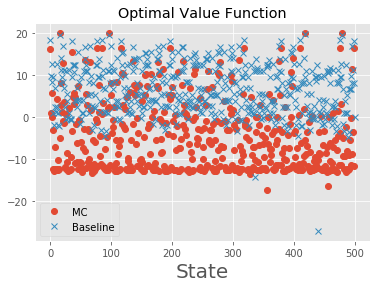

In [7]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
baseline = np.load('baseline.npy')
plot_value_function(V, baseline, title="Optimal Value Function")
# plot_Q_table()
with open('qtable_mc','w') as fp:
    fp.write(str(Q))